**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,143 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import tensorflow as tf
#tf.enable_eager_execution()
tf.VERSION


'1.12.0'

In [3]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   100M      0  0:00:05  0:00:05 --:--:--  107M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  29.0M      0 --:--:-- --:--:-- --:--:-- 29.0M


In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)): # in total 7 levels zoom
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

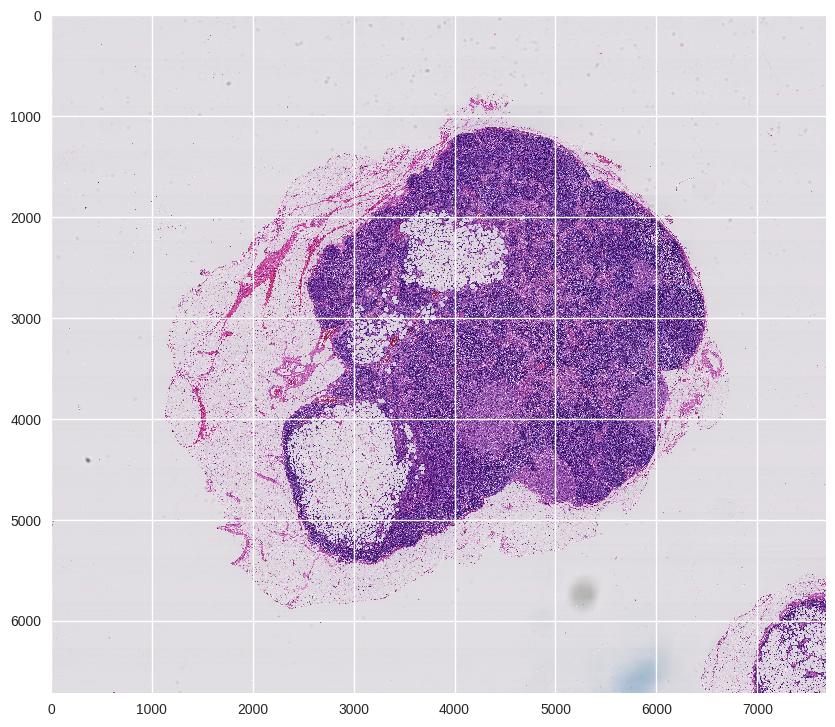

In [6]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#tumor_110
slide1_id = '1tCvyQIXadK0TSJlrwmkQ38caD1HsjevQ'
slideFile1 = drive.CreateFile({'id': slide1_id})
mask1_id = '1jZKrrj-mat0J_ur0CNhkeoYD1Fu-DtJu'
maskFile1 = drive.CreateFile({'id': mask1_id})

#tumor_101
slide2_id = '1vhm5D7106bsCRcf2aTp8r3Y1GLjAsRt_'
slideFile2 = drive.CreateFile({'id': slide2_id})
mask2_id = '1zx_wc1SHnlz_umsqLB0xV13KcVvnbRD3'
maskFile2 = drive.CreateFile({'id': mask2_id})

#094
slide3_id = '1n2pIh-2-wTO0Er5YKye-84YEFsbpq2UH'
slideFile3 = drive.CreateFile({'id': slide3_id})
mask3_id = '1ngSHKv9aM8irpP69lziNVYaEo5hxkDnP'
maskFile3 = drive.CreateFile({'id': mask3_id})

#091
slide4_id = '11RzjCE_ySgk10IPAJEwv4bfgmaBT2dJP'
slideFile4 = drive.CreateFile({'id': slide4_id})
mask4_id = '1hopHZjnPwR7IHMozgJDBre5rdvR_zx0Y'
maskFile4 = drive.CreateFile({'id': mask4_id})

#084
slide5_id = '1fnNUMAhZV5zkFP8joNZ3WexaWSywdtgI'
slideFile5 = drive.CreateFile({'id': slide5_id})
mask5_id = '1OWJQkLp2aMOtAqNQVXWacNN-S3P00bA3'
maskFile5 = drive.CreateFile({'id': mask5_id})

#078
slide6_id = '1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C'
slideFile6 = drive.CreateFile({'id': slide6_id})
mask6_id = '1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq'
maskFile6 = drive.CreateFile({'id': mask6_id})

#075
slide7_id = '173lssx5bG7u4iQQNtAJRYm4DNRsIupDK'
slideFile7 = drive.CreateFile({'id': slide7_id})
mask7_id = '16aeh1alpL4Ql5SpNVwWYELakXPzH7Fd3'
maskFile7 = drive.CreateFile({'id': mask7_id})


In [0]:
# print('Created file %s with mimeType %s' % (slideFile['title'], slideFile['mimeType']))
# print('Created file %s with mimeType %s' % (maskFile['title'], maskFile['mimeType']))

In [0]:
slideFile1.GetContentFile("tumor_110.tif")
maskFile1.GetContentFile("tumor_110_mask.tif")

slideFile2.GetContentFile("tumor_101.tif")
maskFile2.GetContentFile("tumor_101_mask.tif")

slideFile3.GetContentFile("tumor_094.tif")
maskFile3.GetContentFile("tumor_094_mask.tif")

slideFile4.GetContentFile("tumor_091.tif")
maskFile4.GetContentFile("tumor_091_mask.tif")

slideFile5.GetContentFile("tumor_084.tif")
maskFile5.GetContentFile("tumor_084_mask.tif")

slideFile6.GetContentFile("tumor_078.tif")
maskFile6.GetContentFile("tumor_078_mask.tif")

slideFile7.GetContentFile("tumor_075.tif")
maskFile7.GetContentFile("tumor_075_mask.tif")

In [0]:
slide1 = open_slide("tumor_110.tif")
tumor_mask1 = open_slide("tumor_110_mask.tif")
slide2 = open_slide("tumor_101.tif")
tumor_mask2 = open_slide("tumor_101_mask.tif")
slide3 = open_slide("tumor_094.tif")
tumor_mask3 = open_slide("tumor_094_mask.tif")
slide4 = open_slide("tumor_091.tif")
tumor_mask4 = open_slide("tumor_091_mask.tif")
slide5 = open_slide("tumor_084.tif")
tumor_mask5 = open_slide("tumor_084_mask.tif")
slide6 = open_slide("tumor_078.tif")
tumor_mask6 = open_slide("tumor_078_mask.tif")
slide7 = open_slide("tumor_075.tif")
tumor_mask7 = open_slide("tumor_075_mask.tif")

In [0]:
# print("slide level", len(slide2.level_dimensions))
# print("tumor level", len(tumor_mask2.level_dimensions))
# for i in range(len(tumor_mask2.level_dimensions)): # in total 7 levels zoom
#     print("Level %d, dimensions: %s downsample factor %d" % (i, 
#                                                              slide2.level_dimensions[i], 
#                                                              slide2.level_downsamples[i]))
#     assert tumor_mask2.level_dimensions[i][0] == slide2.level_dimensions[i][0]
#     assert tumor_mask2.level_dimensions[i][1] == slide2.level_dimensions[i][1]

# # Verify downsampling works as expected

# width, height = slide2.level_dimensions[7]
# assert width * slide2.level_downsamples[7] == slide2.level_dimensions[0][0]
# assert height * slide2.level_downsamples[7] == slide2.level_dimensions[0][1]

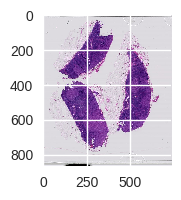

In [13]:
slide_image6 = read_slide(slide6, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide6.level_dimensions[7][0], 
                         height=slide6.level_dimensions[7][1])

plt.figure(figsize=(2,2), dpi=100)
plt.imshow(slide_image6)

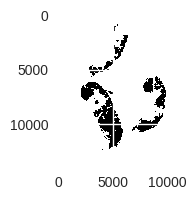

In [14]:
mask_image6 = read_slide(tumor_mask6, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide6.level_dimensions[3][0], 
                        height=slide6.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image6 = mask_image6[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(2,2), dpi=100)
plt.imshow(mask_image6)

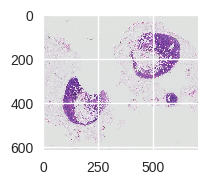

In [15]:
slide_image7 = read_slide(slide7, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide7.level_dimensions[7][0], 
                         height=slide7.level_dimensions[7][1])

plt.figure(figsize=(2,2), dpi=100)
plt.imshow(slide_image7)

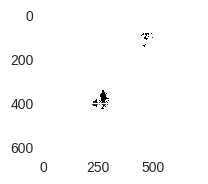

In [16]:
mask_image7 = read_slide(tumor_mask7, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide7.level_dimensions[7][0], 
                        height=slide7.level_dimensions[7][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image7 = mask_image7[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(2,2), dpi=100)
plt.imshow(mask_image7)